In [111]:
from random_generation import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import euclidean
import pickle

## Data generation

### Definición de los sets

In [223]:
i_set = [f"i{i+1}" for i in range(10)]
j_set = ["j1"]
pf_set = ["pf1"]
c_set = ["oil", "gas", "water"]
d_set = ["d1", "d2", "d3", "d4"]
diam = [("d1", 8), ("d2", 12), ("d3", 16), ("d4", 20)]

pw_set = [f"pw{i+1}" for i in range(100)]

n_set = i_set + j_set + pf_set

arcs = [(n, nn) for n in i_set for nn in j_set] + [("j1", "pf1")]

### Loc generation

In [224]:
def generate_random_coordinates(grid_dim: tuple[int, int], n_points: int, seed: int = None) -> list[tuple[float, float]]:
    """
    Generate a list of random (x, y) coordinates within a grid of given dimensions.

    Args:
        grid_dim: Tuple (width, height) of the grid.
        n_points: Number of random points to generate.
        seed: Optional random seed for reproducibility.

    Returns:
        List of (x, y) tuples.
    """
    if seed is not None:
        np.random.seed(seed)
        
    width, height = grid_dim
    x_coords = np.random.uniform(0, width, n_points)
    y_coords = np.random.uniform(0, height, n_points)
    return list(zip(x_coords, y_coords))

In [225]:
len_x = 10 # Grid width
len_y = 10 # Grid height

In [226]:
i_coords = generate_random_coordinates((len_x, len_y), len(i_set))

Crear grafo en función de las distancias

In [227]:
G = nx.Graph()

for node, coord in zip(i_set, i_coords):
    G.add_node(node, pos=coord, node_type='well')

G.add_node("j1", pos=(len_x/2, len_y/2), node_type='junction')
G.add_node("pf1", pos=(len_x/2, 1+len_y/2), node_type='processing_facility')

for u, v in arcs:
    G.add_edge(u, v)

In [228]:
coords_dict = {i: coord for i, coord in zip(i_set, i_coords)}
coords_dict["j1"] = (len_x/2, len_y/2)
coords_dict["pf1"] = (len_x/2, 1+len_y/2)

In [229]:
distance_dict = {}
for (n,nn) in arcs:
    distance_dict[(n, nn)] = euclidean(coords_dict[n], coords_dict[nn])

In [230]:
distance_dict

{('i1', 'j1'): 3.1939633299545536,
 ('i2', 'j1'): 2.73654582285629,
 ('i3', 'j1'): 3.7745775233287766,
 ('i4', 'j1'): 1.251654313517687,
 ('i5', 'j1'): 4.4764916852585985,
 ('i6', 'j1'): 2.562245965490344,
 ('i7', 'j1'): 6.511833124594103,
 ('i8', 'j1'): 3.2930414782052084,
 ('i9', 'j1'): 3.497934422656224,
 ('i10', 'j1'): 3.2602214173931565,
 ('j1', 'pf1'): 1.0}

In [231]:
loc_x = [(k, v[0]) for k, v in coords_dict.items()]
loc_y = [(k, v[1]) for k, v in coords_dict.items()]
dist = [(k[0], k[1], v) for k, v in distance_dict.items()]

### Generación de perfiles productivos y WHP

In [232]:
base_p = [0.15, 0.3, 0.55]
base_oil_profile = [6500, 6100, 5200, 4400, 4000, 3700, 3400, 3200, 3000, 2800, 2600, 2400, 2260, 2110, 1970, 1850, 1730, 1610, 1510, 1410]

q_prod_dict = generate_random_wells_dirichlet(
        base_p, base_oil_profile, n_wells=len(i_set),
        random_state=42, noise=True, noise_level=0.1
    )

In [233]:
t_set = [f"t{i+1}" for i in range(len(base_oil_profile))]

In [234]:
tp_set = t_set

In [235]:
pwell_dict = {}

for (i,t) in [(i_, t_) for i_ in i_set for t_ in t_set]:
    oil, gas, water = q_prod_dict[(int(t[1:]), i, "oil")], q_prod_dict[(int(t[1:]), i, "gas")], q_prod_dict[(int(t[1:]), i, "water")]
    pwell_dict[i, t] = estimate_whp(oil, gas, water, unit="MPa")

In [236]:
pwell = []

for (k,v) in pwell_dict.items():
    i, t = k
    pwell.append((i, t, v))

In [237]:
q_prod = []

for (k,v) in q_prod_dict.items():
    t_int, well, comp = k
    q_prod.append((well, f"t{t_int}", comp, v))

### Asignar start times

In [238]:
def assign_start_times(n, m, seed=None):
    """
    Assign start times to wells with uniform randomness,
    ensuring that no start time is assigned to more than n/m wells.

    Parameters:
        n (int): Number of wells
        m (int): Number of possible start times
        seed (int, optional): Random seed for reproducibility

    Returns:
        np.ndarray: Array of start times for each well
    """
    rng = np.random.default_rng(seed)

    # Maximum number of wells per start time
    max_per_time = int(np.ceil(n / m))

    # Build the pool of start times
    pool = np.repeat(np.arange(1, m+1), max_per_time)

    # Take exactly n assignments from the pool
    start_times = rng.choice(pool, size=n, replace=False)
    rng.shuffle(start_times)

    return start_times

In [239]:
st_times_list = assign_start_times(len(i_set), 10, seed=42)

In [240]:
start_times = [(i, st) for i, st in zip(i_set, st_times_list)]

### Inicialización parámetros LM

In [241]:
ixlm_ub = []
ylp = []
allowed_int = []

for (j,pf,d,t) in [(j_, pf_, d_, t_) for j_ in j_set for pf_ in pf_set for d_ in d_set for t_ in t_set]:
    ixlm_ub.append(("pw1", j, pf, d, t, 3))
    ylp.append(("pw1", j, pf, d, t, 1))
    allowed_int.append((j, pf, d, t, 1))

### Fluid-dynamic parameters

In [242]:
hffl = 0.025
rho_liq = 850  # kg/m3
pmin_pf = 0.551581 # MPa
maxPress = max(pwell_dict.values())
dp_max = maxPress - pmin_pf  # MPa

### Fill data dict

In [243]:
data = {
    "n": n_set,
    "i": i_set,
    "j": j_set,
    "pf": pf_set,
    "arcs": arcs,
    "t": t_set,
    "tp": tp_set,
    "c": c_set,
    "d": d_set,
    "pw": pw_set,
    "Qprod": q_prod,
    "st_time": start_times,
    "diam": diam,
    "loc_x": loc_x,
    "loc_y": loc_y,
    "dist": dist,
    "hffl": hffl,
    "rho_liq": rho_liq,
    "pwell": pwell,
    "pmin_pf": pmin_pf,
    "maxPress": maxPress,
    "dp_max": dp_max,
    "ixlm_ub": ixlm_ub,
    "ylp": ylp,
    "allowed_int": allowed_int
}

In [244]:
with open("GatheringModelData.pkl", "wb") as f:
    pickle.dump(data, f)

## Plot validation

In [ ]:
def plot_whp_evolution(wells: list[str], pwell_dict: dict[tuple, float], t_set: list[str]):
    plt.figure(figsize=(10, 5))
    for well in wells:
        whp_values = [pwell_dict.get((well, t), None) for t in t_set]
        plt.plot(t_set, whp_values, marker='o', label=well)
    plt.title('Wellhead Pressure Evolution')
    plt.xlabel('Time Period')
    plt.ylabel('WHP (MPa)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_production_evolution(wells: list[str], q_prod_dict: dict[tuple, float], t_set: list[str], component: str):
    plt.figure(figsize=(10, 5))
    for well in wells:
        prod_values = [q_prod_dict.get((int(t[1:]), well, component), None) for t in t_set]
        plt.plot(t_set, prod_values, marker='o', label=well)
    plt.title(f'Production Evolution - {component.capitalize()}')
    plt.xlabel('Time Period')
    plt.ylabel(f'Production ({component})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_all_components_evolution(
    well: str,
    q_prod_dict: dict[tuple, float],
    t_set: list[str],
    components: list[str] = ["oil", "gas", "water"]
):
    plt.figure(figsize=(10, 5))
    for comp in components:
        prod_values = [q_prod_dict.get((int(t[1:]), well, comp), None) for t in t_set]
        if comp == "oil" or comp == "water":
            label = f"{comp.capitalize()} (bbl/day)"
        elif comp == "gas":
            label = "Gas (mscf/day)"
        else:
            label = comp.capitalize()
        plt.plot(t_set, prod_values, marker='o', label=label)
    plt.title(f'Production Evolution for {well}')
    plt.xlabel('Time Period')
    plt.ylabel('Production')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_pressure_vs_production(well: str, pwell_dict: dict, q_prod_dict: dict, t_set: list[str], component: str = "oil"):
    whp_values = [pwell_dict.get((well, t), None) for t in t_set]
    prod_values = [q_prod_dict.get((int(t[1:]), well, component), None) for t in t_set]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Pressure as black line
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('WHP (MPa)', color='black')
    ax1.plot(t_set, whp_values, marker='o', color='black', label='Well-head Pressure')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)  # ensure WHP starts at 0

    # Production as gray filled area
    ax2 = ax1.twinx()
    ax2.set_ylabel(f'Production ({component}) [bbl/day]', color='black')
    ax2.fill_between(t_set, prod_values, color='gray', alpha=0.3, label=f'{component.capitalize()} Production')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'Pressure and {component.capitalize()} Production Evolution for {well}')
    fig.tight_layout()
    plt.show()

In [63]:
def plot_grid_from_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    node_types = nx.get_node_attributes(G, 'node_type')
    colors = []
    color_map = {'well': 'skyblue', 'junction': 'orange', 'processing_facility': 'green'}
    for n in G.nodes():
        colors.append(color_map.get(node_types.get(n, ''), 'gray'))
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500, edge_color='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

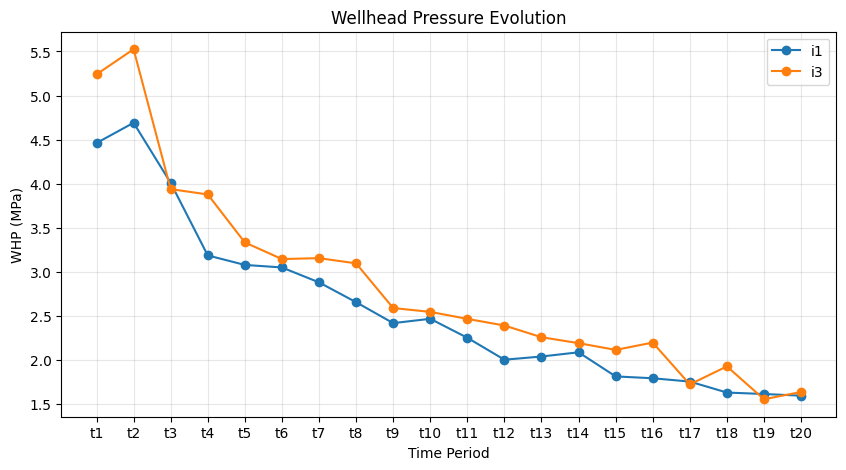

In [138]:
plot_whp_evolution(["i1", "i3"], pwell_dict, t_set)

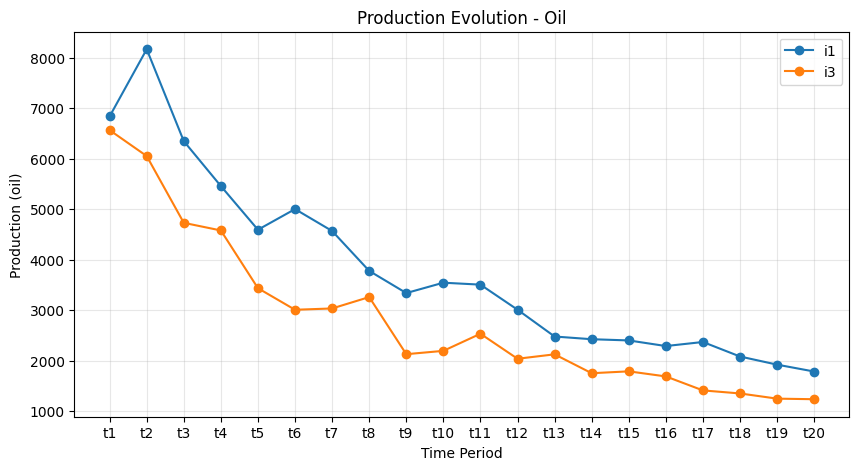

In [137]:
plot_production_evolution(["i1", "i3"], q_prod_dict, t_set, component="oil")

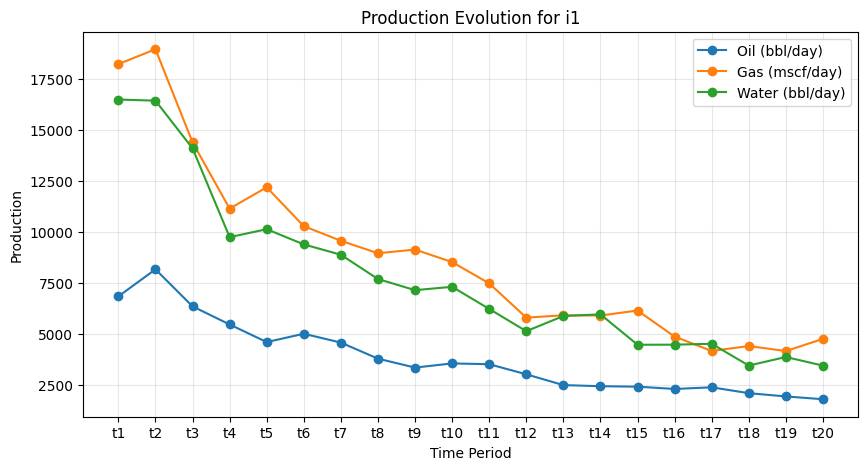

In [144]:
plot_all_components_evolution("i1", q_prod_dict, t_set)

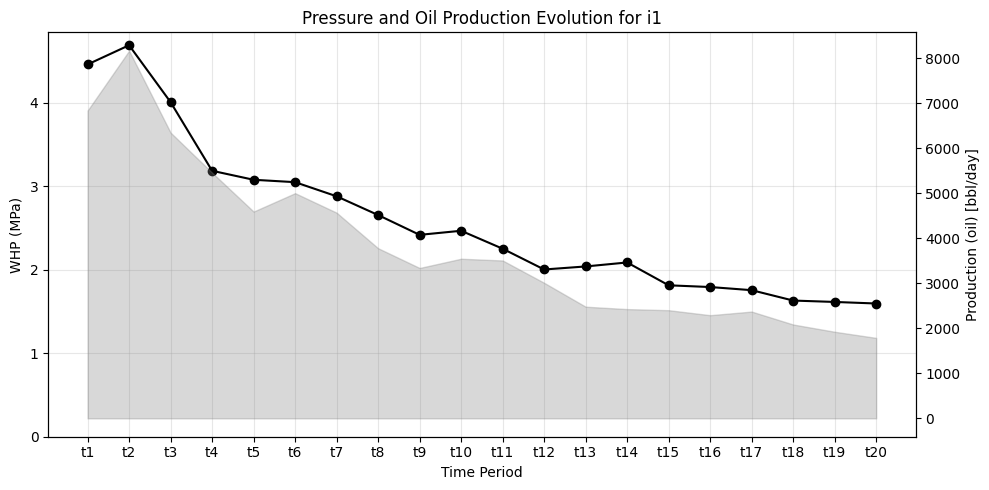

In [154]:
plot_pressure_vs_production("i1", pwell_dict, q_prod_dict, t_set, component="oil")

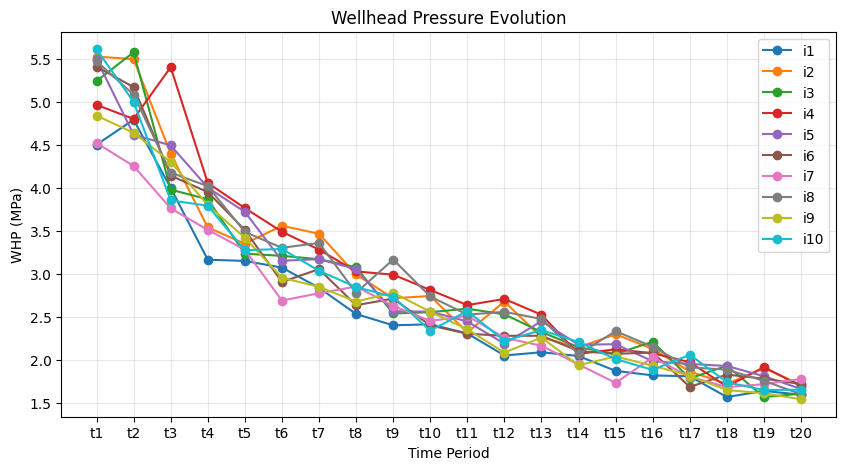

In [104]:
plot_whp_evolution(i_set, pwell_dict, t_set)

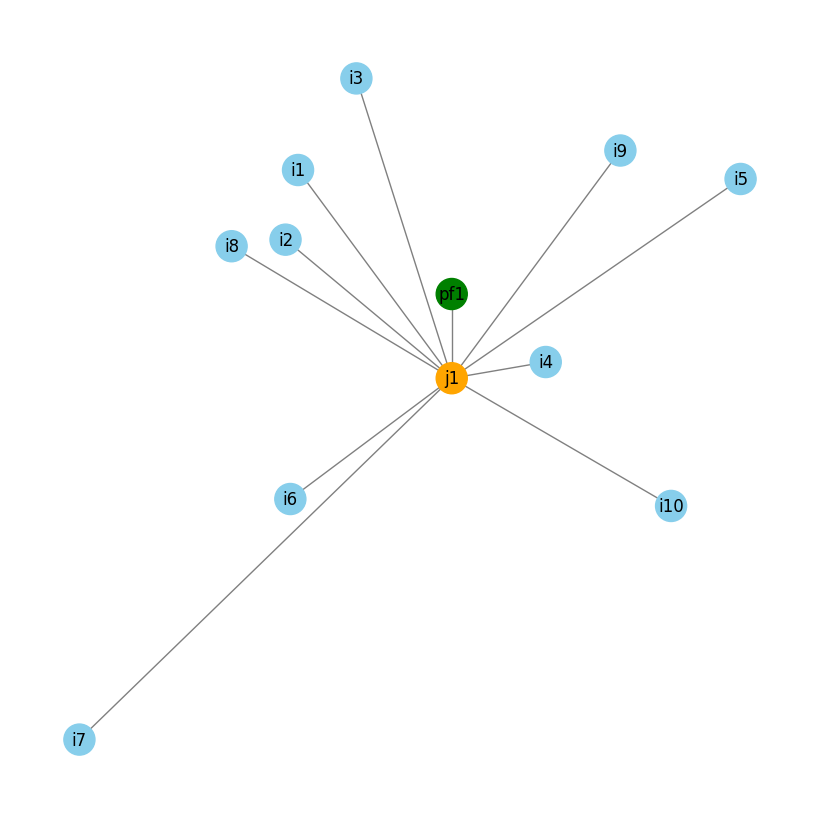

In [245]:
plot_grid_from_graph(G)